
📋 강한 증강 (Strong) 종합 결과표 (Markdown 형식)
아래 내용을 복사하여 README.md 파일에 붙여넣으세요.
| 모델 설정 | 학습 방식 그룹 | 최고 정확도 (%) | 성능 유지율 (%) |
|:---|:---|:---:|:---:|
| Supervised Hyperbolic          | Supervised           | 95.55 | **62.51** |
| Supervised Linear              | Supervised           | 95.83 | **52.98** |
| SSL LinearEval Hyperbolic      | SSL-Linear Eval      | 92.67 | **52.62** |
| SSL FineTune Linear            | SSL-Finetune         | 97.32 | **47.76** |
| SSL LinearEval Linear          | SSL-Linear Eval      | 92.23 | **46.30** |
| SSL FineTune Hyperbolic        | SSL-Finetune         | 98.03 | **43.78** |

📋 약한 증강 (Weak) 종합 결과표 (Markdown 형식)
아래 내용을 복사하여 README.md 파일에 붙여넣으세요.
| 모델 설정 | 학습 방식 그룹 | 최고 정확도 (%) | 성능 유지율 (%) |
|:---|:---|:---:|:---:|
| Supervised Hyperbolic          | Supervised           | 95.55 | **62.51** |
| SSL FineTune Linear            | SSL-Finetune         | 97.96 | **53.59** |
| SSL LinearEval Linear          | SSL-Linear Eval      | 91.79 | **53.48** |
| Supervised

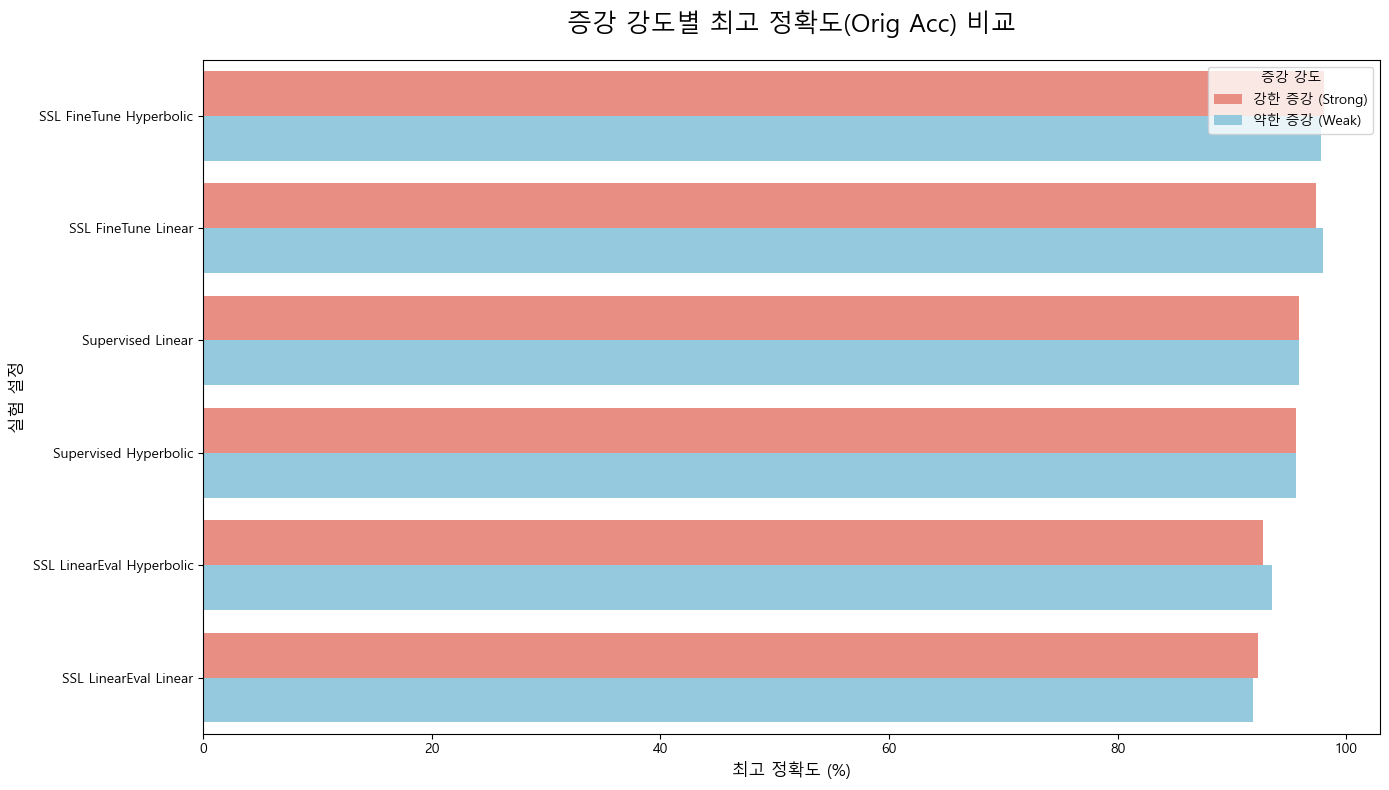

✅ 증강 강도별 안정성(Retention) 비교 그래프:


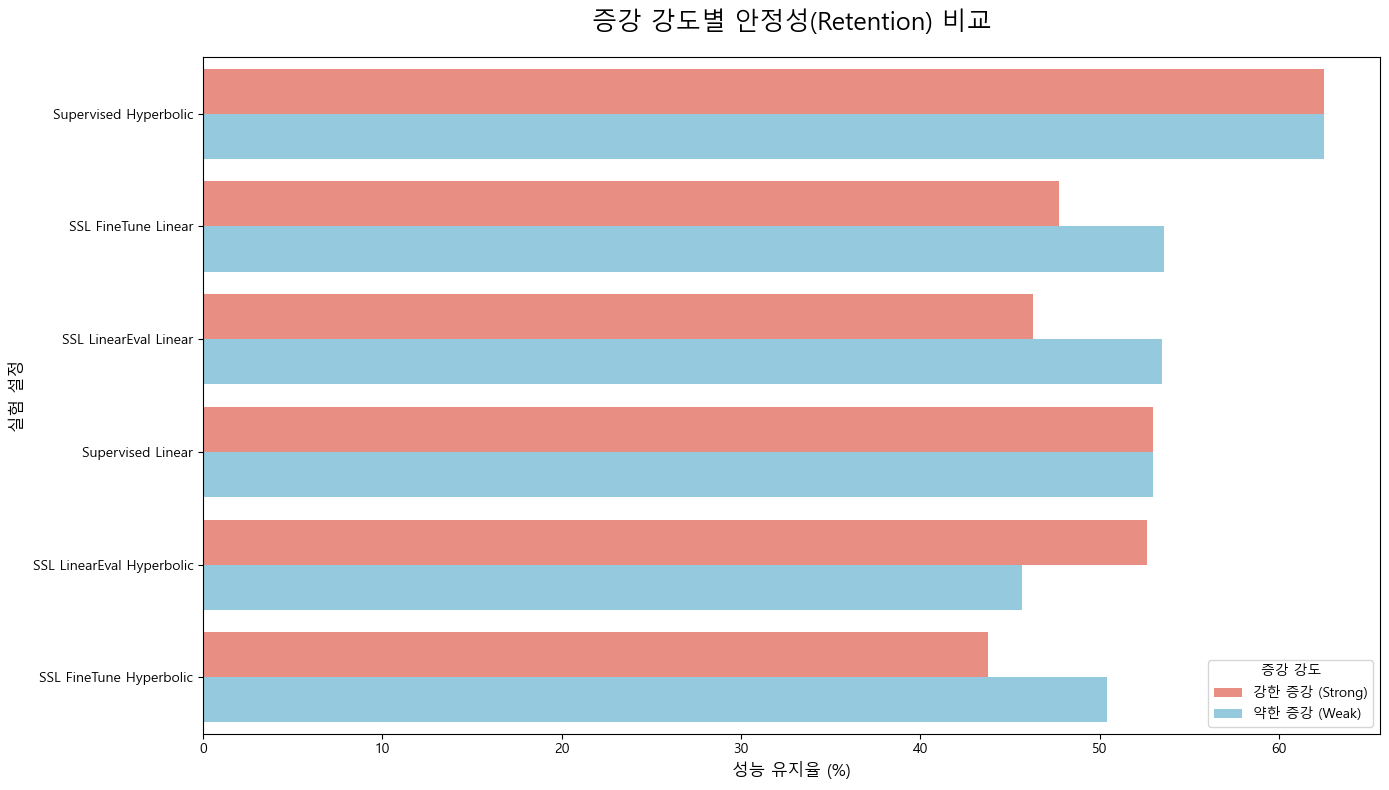

✅ 증강 강도별 성능-안정성 관계도 그래프:


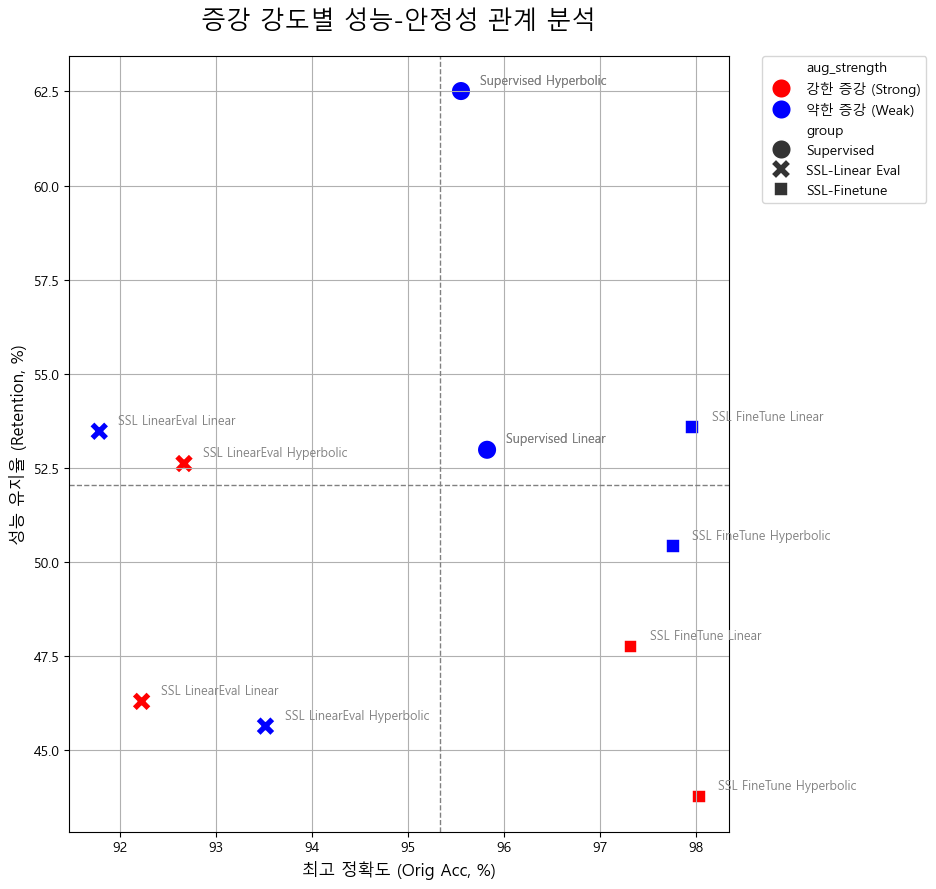


모든 비교 시각화가 완료되었습니다.


In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def setup_korean_font():
    """
    한글 폰트를 설정합니다. Windows, Mac 환경에 맞게 폰트를 지정해주세요.
    """
    try:
        # Windows: 'Malgun Gothic', Mac: 'AppleGothic'
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except RuntimeError:
        print("경고: 'Malgun Gothic' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

def load_and_process_data(file_config):
    """
    여러 JSON 파일을 불러와 'aug_strength' 태그를 붙여 하나의 DataFrame으로 통합합니다.
    """
    all_data = []
    for tag, filepath in file_config.items():
        if not os.path.exists(filepath):
            print(f"경고: 파일을 찾을 수 없습니다 - {filepath}")
            continue
        
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        for item in data:
            item['aug_strength'] = tag
        all_data.extend(data)

    if not all_data:
        print("오류: 시각화할 데이터를 불러오지 못했습니다. 파일 경로를 확인해주세요.")
        return None

    df = pd.DataFrame(all_data)
    
    # 데이터 전처리
    df['orig_acc_pct'] = df['orig_acc'] * 100
    df['group'] = df.apply(
        lambda row: f"SSL-{row['mode'].replace('_', ' ').title()}" if row['method'] == 'ssl' else 'Supervised',
        axis=1
    )
    df['config_readable'] = df['config'].str.replace('_', ' ')
    
    # retention 값이 문자열일 경우 숫자로 변환
    if 'retention' in df.columns and df['retention'].dtype == 'object':
        df['retention'] = pd.to_numeric(df['retention'].str.replace('%', ''), errors='coerce')

    return df

def print_markdown_summary(df):
    """
    실험 결과 요약표를 Markdown 형식으로 출력합니다.
    """
    # 증강 강도별로 데이터를 분리하여 처리
    for strength in df['aug_strength'].unique():
        subset_df = df[df['aug_strength'] == strength].copy()
        summary_df = subset_df[['config_readable', 'group', 'orig_acc_pct', 'retention']]
        summary_df = summary_df.sort_values('retention', ascending=False)

        print("\n" + "="*80)
        print(f"📋 {strength} 종합 결과표 (Markdown 형식)")
        print("아래 내용을 복사하여 README.md 파일에 붙여넣으세요.")
        print("="*80)

        # 헤더 출력
        print("| 모델 설정 | 학습 방식 그룹 | 최고 정확도 (%) | 성능 유지율 (%) |")
        print("|:---|:---|:---:|:---:|")

        # 내용 출력
        for _, row in summary_df.iterrows():
            print(f"| {row['config_readable']:<30} | {row['group']:<20} | {row['orig_acc_pct']:.2f} | **{row['retention']:.2f}** |")
        
    print("="*80 + "\n")


def visualize_grouped_barchart(df, metric_col, title, xlabel):
    """증강 강도별로 그룹화된 막대그래프를 생성합니다."""
    plt.figure(figsize=(14, 8))
    
    sns.barplot(
        x=metric_col,
        y='config_readable',
        hue='aug_strength',
        data=df.sort_values([metric_col, 'config_readable'], ascending=[False, True]),
        palette={'강한 증강 (Strong)': 'salmon', '약한 증강 (Weak)': 'skyblue'}
    )
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('실험 설정', fontsize=12)
    plt.legend(title='증강 강도')
    
    plt.tight_layout()
    print(f"✅ {title} 그래프:")
    plt.show()

def visualize_accuracy_vs_retention_comparison(df):
    """증강 강도별 성능-안정성 관계도를 생성합니다."""
    plt.figure(figsize=(12, 9))
    
    sns.scatterplot(
        x='orig_acc_pct',
        y='retention',
        data=df,
        hue='aug_strength',
        style='group',
        s=200,
        palette={'강한 증강 (Strong)': 'red', '약한 증강 (Weak)': 'blue'}
    )

    plt.title('증강 강도별 성능-안정성 관계 분석', fontsize=18, pad=20)
    plt.xlabel('최고 정확도 (Orig Acc, %)', fontsize=12)
    plt.ylabel('성능 유지율 (Retention, %)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    
    # 평균선 추가
    avg_retention = df['retention'].mean()
    avg_accuracy = df['orig_acc_pct'].mean()
    plt.axhline(y=avg_retention, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=avg_accuracy, color='gray', linestyle='--', linewidth=1)
    
    # 각 점에 라벨 추가
    for i in range(df.shape[0]):
        row = df.iloc[i]
        plt.text(
            x=row['orig_acc_pct'] + 0.2, 
            y=row['retention'] + 0.2,
            s=f"{row['config_readable']}",
            fontdict=dict(color='gray', size=9)
        )

    plt.tight_layout(rect=[0, 0, 0.8, 1])
    print("✅ 증강 강도별 성능-안정성 관계도 그래프:")
    plt.show()

def main():
    """메인 실행 함수"""
    # --- 설정 ---
    # 각 실험 결과 JSON 파일의 경로를 지정합니다.
    JSON_FILE_CONFIG = {
        '강한 증강 (Strong)': 'C://Users/park9/HAR/SSL_HAR/RESULTS/BASIC/high/supervised_vs_ssl_results.json',
        '약한 증강 (Weak)': 'C://Users/park9/HAR/SSL_HAR/RESULTS/BASIC/low/supervised_vs_ssl_results.json'
    }
    
    setup_korean_font()
    
    # 데이터 로드 및 통합
    df = load_and_process_data(JSON_FILE_CONFIG)
    
    if df is not None:
        # Markdown 테이블 생성
        print_markdown_summary(df)

        # 시각화 함수 호출
        visualize_grouped_barchart(df, 'orig_acc_pct', '증강 강도별 최고 정확도(Orig Acc) 비교', '최고 정확도 (%)')
        visualize_grouped_barchart(df, 'retention', '증강 강도별 안정성(Retention) 비교', '성능 유지율 (%)')
        visualize_accuracy_vs_retention_comparison(df)
        
        print("\n모든 비교 시각화가 완료되었습니다.")

if __name__ == '__main__':
    main()

